In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D
import torch
import gpytorch
from math import pi

import matplotlib.pyplot as plt
from util import *

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm

torch.set_default_tensor_type(torch.DoubleTensor)

name = 'GP Linear'

train_x = torch.tensor([[1/13,1/6],[1/13,3/8],[1/13,7/12],[1/13,19/24],[1/13,1],
                        [5/13,1/6],[5/13,3/8],[5/13,7/12],[5/13,19/24],[5/13,1],
                        [9/13,1/6],[9/13,3/8],[9/13,7/12],[9/13,19/24],[9/13,1],
                        [1,1/6],[1,3/8],[1,7/12],[1,19/24],[1,1]], dtype=torch.double)

train_y = torch.tensor([0,2,2,1,2,2,5,5,4,4,8,6,7,10,6,6,9,9,8,8], dtype=torch.double)


x1_range = torch.linspace(0, 1, 53)
x2_range = torch.linspace(0, 1, 97)
X1, X2 = torch.meshgrid(x1_range, x2_range, indexing="ij")
xs = torch.vstack((X1.flatten(), X2.flatten())).transpose(-1, -2)

In [2]:
class LinearMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(2)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
# lenthscale = torch.tensor([6.3, 63.0]) ##############给定长度尺度的先验数值
noise = 0.01

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = LinearMeanGPModel(train_x, train_y, likelihood)


# model.covar_module.base_kernel.lengthscale = lenthscale ###############
model.likelihood.noise = noise

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [4]:
losses = []
weights = []
biases = []
for i in tqdm(range(10000)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    weights.append(model.mean_module.weights.detach().cpu().clone().numpy())  
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

d:\HybridOpt\.conda\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2197.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

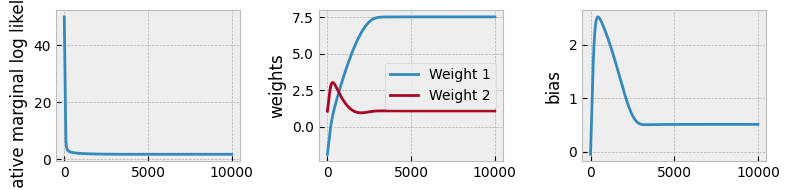

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")


weights = np.array([w for w in weights])  
ax[1].plot(weights[:, 0], label="Weight 1")  
ax[1].plot(weights[:, 1], label="Weight 2") 
ax[1].set_ylabel("weights")
ax[1].legend()

ax[2].plot(biases)
ax[2].set_ylabel("bias")
plt.tight_layout()

In [6]:
print(model.covar_module.base_kernel.lengthscale)
print(model.likelihood.noise)

tensor([[0.0650, 0.0462]], grad_fn=<SoftplusBackward0>)
tensor([0.0200], grad_fn=<AddBackward0>)


In [7]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))

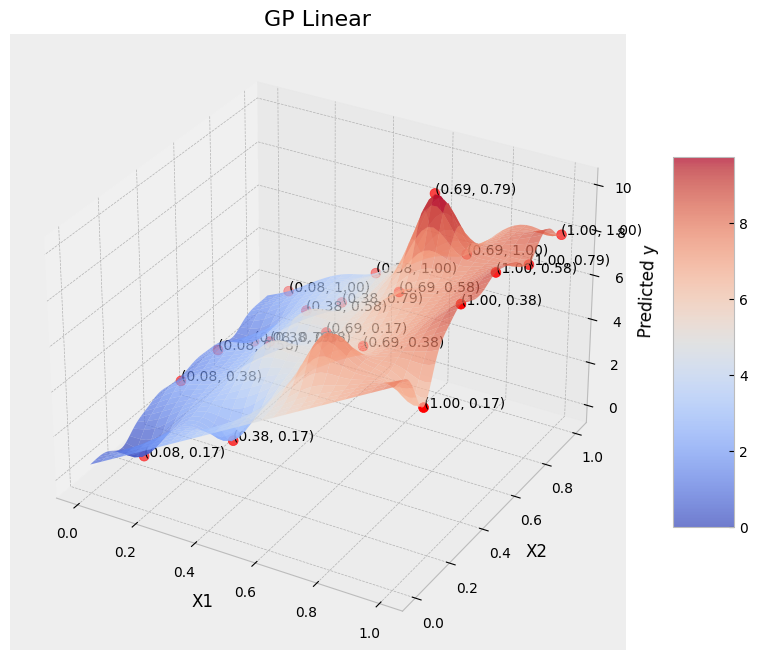

In [8]:
visualize_gp_belief(name, model, likelihood, train_x, train_y, X1, X2, xs)

In [9]:
x1_fine = torch.linspace(2/130, 8/130, 4)  # 在50到60之间生成更多的点
x2_fine = torch.linspace(115/2400, 235/2400, 9)  # 在200到350之间生成更多的点
X1_fine, X2_fine = torch.meshgrid(x1_fine, x2_fine, indexing="ij")
xs_fine= torch.vstack((X1_fine.flatten(), X2_fine.flatten())).transpose(-1, -2) 
xs= torch.concatenate((xs,xs_fine))

In [10]:
results = []
for i in range(20):
    posterior = model(xs)
    sample = posterior.sample()
    result = xs[sample.argmin()]
    results.append(result)
suggest_x = torch.stack(results)
suggest_x

tensor([[0.1154, 0.1875],
        [0.0308, 0.0979],
        [0.0192, 0.6771],
        [0.0769, 0.1875],
        [0.0000, 0.2500],
        [0.0577, 0.1250],
        [0.0385, 0.0104],
        [0.1346, 0.1667],
        [0.0000, 0.2500],
        [0.0192, 0.0312],
        [0.0962, 0.2188],
        [0.1923, 0.0312],
        [0.1154, 0.2083],
        [0.0000, 0.1042],
        [0.2308, 0.1250],
        [0.0577, 0.1875],
        [0.0000, 0.4583],
        [0.1346, 0.0625],
        [0.0769, 0.0625],
        [0.0000, 0.1354]])

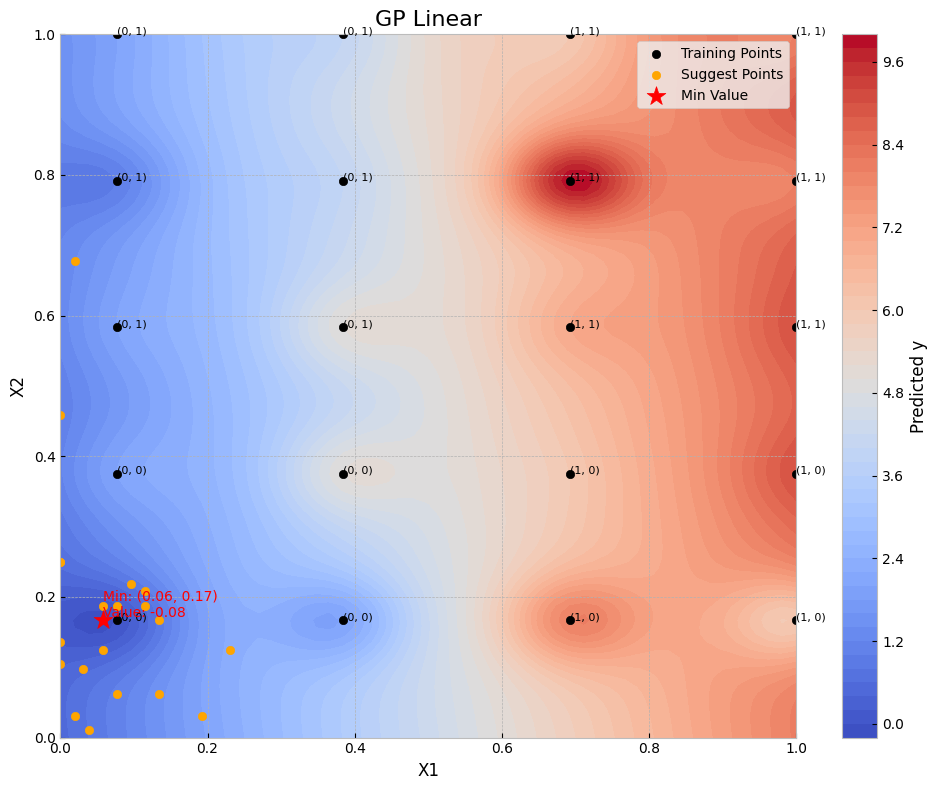

In [11]:
visualize_2d_contour(name, predictive_distribution, train_x, X1, X2, xs, suggest_x)

In [19]:
with torch.no_grad():  
    observed_pred = model(suggest_x)
suggest_y= observed_pred.mean

x1 = suggest_x[:,0]*130+50
x2 = suggest_x[:,1]*2400+100
df = pd.DataFrame({  
    "x1":x1,   
    "x2":x2,
    "predict_y":suggest_y.flatten(),
})
df.to_csv('GP_linear.csv',index=False)

In [20]:
df

,x1,x2,predict_y
0,65.0,550.0,0.630747
1,54.0,335.0,0.524727
2,52.5,1725.0,1.380901
3,60.0,550.0,0.159238
4,50.0,700.0,0.663481
5,57.5,400.0,0.279805
6,55.0,125.0,0.807741
7,67.5,500.0,0.857559
8,50.0,700.0,0.663481
9,52.5,175.0,0.677103
